## Stationary Navier-Stokes with Picard Linearization

In [4]:
using Revise
using CairoMakie
using Symbolics
using Latexify
using BenchmarkTools
include("RBFunctions.jl")
using Plots
using LinearAlgebra
using DoubleFloats

In [5]:
@variables ϵ r x₁ x₂ t Δt;
const nu = 1.0
μ = 0.001
ρ = 1.0
#ϕ = 1//945 * ((ϵ*r)^5 +15*(ϵ*r)^3 + 105*(ϵ*r)^2 + 945*(ϵ*r)+ 945)* exp(-ϵ*r)
#ϕ = exp(-r^2*ϵ^2)
#ϕ = (1-r*ϵ)^10 * (429*(r*ϵ)^4 + 450*(r*ϵ)^3 + 210*(r*ϵ)^2 + 50*(r*ϵ)+5)
ϕ = r^7
ϕ2 = r^7
ϕ = simplify(ϕ,expand = true)
ϕ = substitute(ϕ, r=>sqrt(x₁^2 + x₂^2)) 
ϕ2 = substitute(ϕ2, r=>sqrt(x₁^2 + x₂^2)) 
#display(ϕ)  
Δ(exprs) = expand_derivatives((Differential(x₁)^2)(exprs) + (Differential(x₂)^2)(exprs))
∂₁(exprs) = simplify(expand_derivatives(Differential(x₁)(exprs)))
∂₂(exprs) = simplify(expand_derivatives(Differential(x₂)(exprs)))
∂ₜ(exprs) = expand_derivatives(Differential(t)(exprs))

Φ_div = ([-∂₂(∂₂(ϕ)) ∂₁(∂₂(ϕ)) 0.0 ; ∂₁(∂₂(ϕ)) -∂₁(∂₁(ϕ)) 0.0; 0.0 0.0 ϕ2])
ΔΦ_div= Δ.([-∂₂(∂₂(ϕ)) ∂₁(∂₂(ϕ)); ∂₁(∂₂(ϕ)) -∂₁(∂₁(ϕ))])
Φ_curl = ([-∂₁(∂₁(ϕ)) -∂₁(∂₂(ϕ)); -∂₁(∂₂(ϕ)) -∂₂(∂₂(ϕ))])
Φ = [ϕ 0.0 0.0; 0.0 ϕ 0.0;0.0 0.0 ϕ]
#ΔΦ = [Δ(ϕ) 0 ; 0 Δ(ϕ)]

f₁ = 0.0
f₂ = 0.0
f₁ = eval(build_function(f₁,x₁, x₂, t))
f₂ = eval(build_function(f₂,x₁, x₂, t))
zero_func(x₁,x₂,t) = 0.0


λ1y(x) = -(μ/ρ)*Δ(x[1]) -  (1/ρ)*∂₁(x[3])
λ2y(x) = -(μ/ρ)*Δ(x[2]) -  (1/ρ)*∂₂(x[3])
λ3y(x) = x[1]
λ4y(x) = x[2]

λ1x(x) = -(μ/ρ)*Δ(x[1]) + (1/ρ)*∂₁(x[3])
λ2x(x) = -(μ/ρ)*Δ(x[2]) +  (1/ρ)*∂₂(x[3])
λ3x(x) = x[1]
λ4x(x) = x[2]

λu(x) = x[1]
λv(x) = x[2]
λp(x) = x[3]

λ∂₁u(x) = ∂₁(x[1])
λ∂₂u(x) = ∂₂(x[1])
λ∂₁v(x) = ∂₁(x[2])
λ∂₂v(x) = ∂₂(x[2])
display(Φ_div)


3×3 Matrix{Num}:
 -7(sqrt(x₁^2 + x₂^2)^5) - 35(x₂^2)*(sqrt(x₁^2 + x₂^2)^3)    …                    0.0
                            35x₁*x₂*(sqrt(x₁^2 + x₂^2)^3)                         0.0
                                                        0.0     sqrt(x₁^2 + x₂^2)^7

In [6]:
#generate points for lid_driven_cavity
Internal_points,Boundary_points =  generate_2D_equally_spaced_points(40)
N_i = size(Internal_points)[2]
N_b = size(Boundary_points)[2]
N = N_i + N_b
top_points= zeros((2,1+Int(N_b/4)))
side_points = zeros((2,N_b-size(top_points)[2]))
s1,s2 = 1,1
for i in 1:N_b
    if Boundary_points[2,i] == 1.0
        top_points[:,s1] = Boundary_points[:,i]
        s1+=1
    else
        side_points[:,s2] = Boundary_points[:,i]
        s2+=1
    end
end
Boundary_points = hcat(top_points,side_points)
All_points = hcat(Internal_points,Boundary_points)

N_top = size(top_points)[2]
N_side = size(side_points)[2]
println("total number of nodes: ",N)
println("number of internal_nodes: ",N_i)
println(" number of top nodes: ",N_top)
println("number of side nodes: ",N_side)


total number of nodes: 1600
number of internal_nodes: 1444
 number of top nodes: 40
number of side nodes: 116


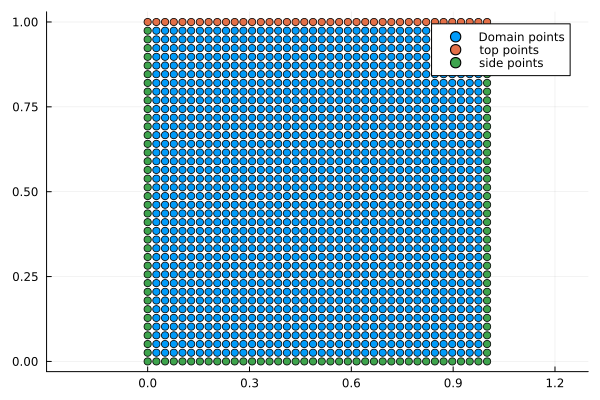

In [7]:
Plots.scatter(Internal_points[1,:],Internal_points[2,:],aspect_ratio=:equal,label = "Domain points")
Plots.scatter!(top_points[1,:],top_points[2,:],aspect_ratio=:equal,label ="top points")
Plots.scatter!(side_points[1,:],side_points[2,:],aspect_ratio=:equal,label ="side points")
#savefig("internal_domain_points.png")

In [8]:

Eval_points, _ =  generate_2D_equally_spaced_points(60)
N_eval = size(Eval_points)[2]

3364

Construct matrices

In [9]:
parameter = 0.1

# Stokes matrix
A_functions = construct_kernel_array(Φ_div,[λ1x,λ2x,λ3x,λ4x],[λ1y,λ2y,λ3y,λ4y])
display(A_functions)
A_functions= compile_kernel_array(A_functions)
A_tensor = crete_block_point_tensors([Internal_points,Internal_points,Boundary_points,Boundary_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
A = generate_block_matrices(A_functions,A_tensor,parameter)
A = flatten(A)

# transformation of coefficients to velocities and pressure
E_functions = construct_kernel_array(Φ_div,[λu,λv,λp],[λ1y,λ2y,λ3y,λ4y])
E_functions = compile_kernel_array(E_functions)
E_tensor = crete_block_point_tensors([Eval_points,Eval_points,Eval_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
E = generate_block_matrices(E_functions,E_tensor,parameter) 
E = flatten(E)

# Matrices for nonlinear terms 

U_functions = construct_kernel_array(Φ_div,[λu],[λ1y,λ2y,λ3y,λ4y])
#display(U_functions)
U_functions = compile_kernel_array(U_functions)
U_tensor = crete_block_point_tensors([Internal_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
U = generate_block_matrices(U_functions,U_tensor,parameter) 
U = flatten(U)

V_functions = construct_kernel_array(Φ_div,[λv],[λ1y,λ2y,λ3y,λ4y])
V_functions = compile_kernel_array(V_functions)
V_tensor = crete_block_point_tensors([Internal_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
V = generate_block_matrices(V_functions,V_tensor,parameter) 
V = flatten(V)

Ux_functions = construct_kernel_array(Φ_div,[λ∂₁u],[λ1y,λ2y,λ3y,λ4y])
Ux_functions = compile_kernel_array(Ux_functions)
Ux_tensor = crete_block_point_tensors([Internal_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
Ux = generate_block_matrices(Ux_functions,Ux_tensor,parameter) 
Ux = flatten(Ux)

Uy_functions = construct_kernel_array(Φ_div,[λ∂₂u],[λ1y,λ2y,λ3y,λ4y])
Uy_functions = compile_kernel_array(Uy_functions)
Uy_tensor = crete_block_point_tensors([Internal_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
Uy = generate_block_matrices(Uy_functions,Uy_tensor,parameter) 
Uy = flatten(Uy)


Vx_functions = construct_kernel_array(Φ_div,[λ∂₁v],[λ1y,λ2y,λ3y,λ4y])
Vx_functions = compile_kernel_array(Vx_functions)
Vx_tensor = crete_block_point_tensors([Internal_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
Vx = generate_block_matrices(Vx_functions,Vx_tensor,parameter) 
Vx = flatten(Vx)

Vy_functions = construct_kernel_array(Φ_div,[λ∂₂v],[λ1y,λ2y,λ3y,λ4y])
Vy_functions = compile_kernel_array(Vy_functions)
Vy_tensor = crete_block_point_tensors([Internal_points],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
Vy = generate_block_matrices(Vy_functions,Vy_tensor,parameter) 
Vy = flatten(Vy)


println(cond(A))

println("done")

function g(t)
    res = zeros(N_b*2)
    res[1:N_top] .= min(t,8.0)
    return res
end

f = generate_vector_function([f₁,f₂],Internal_points)

g(1.2)


print("done")

4×4 Matrix{Num}:
 -0.001(-0.001(((105(x₂^4)) / (sqrt(x₁^2 + x₂^2)^2) + 2(x₁^2)*((-105(x₂^4)) / (sqrt(x₁^2 + x₂^2)^4))) / sqrt(x₁^2 + x₂^2) + ((105(x₁^2)*(x₂^2)) / (sqrt(x₁^2 + x₂^2)^2) - x₁*((-210x₁*(x₂^2)) / (sqrt(x₁^2 + x₂^2)^2) - 2x₁*((-105(x₁^2)*(x₂^2)) / (sqrt(x₁^2 + x₂^2)^4)))) / sqrt(x₁^2 + x₂^2) + (-210(x₂^2)) / sqrt(x₁^2 + x₂^2) + (-315(x₁^2)) / sqrt(x₁^2 + x₂^2) + (-630(x₁^2)) / sqrt(x₁^2 + x₂^2) + (-735(x₂^2)) / sqrt(x₁^2 + x₂^2) + (-x₁*((-105(x₁^3)) / (sqrt(x₁^2 + x₂^2)^2))) / sqrt(x₁^2 + x₂^2) + (-x₁*((-210x₁*(x₂^2)) / (sqrt(x₁^2 + x₂^2)^2))) / sqrt(x₁^2 + x₂^2) + (-x₁*((-x₁*((-105(x₂^4)) / (sqrt(x₁^2 + x₂^2)^2))) / (sqrt(x₁^2 + x₂^2)^2))) / sqrt(x₁^2 + x₂^2) + (-x₁*((-x₁*((-105(x₁^2)*(x₂^2)) / (sqrt(x₁^2 + x₂^2)^2))) / (sqrt(x₁^2 + x₂^2)^2))) / sqrt(x₁^2 + x₂^2) + (-x₁*((-735x₁*(x₂^2)) / (sqrt(x₁^2 + x₂^2)^2))) / sqrt(x₁^2 + x₂^2) - 630sqrt(x₁^2 + x₂^2)) - 0.001(((105(x₂^4)) / (sqrt(x₁^2 + x₂^2)^2) - x₂*((-420(x₂^3)) / (sqrt(x₁^2 + x₂^2)^2) - 2x₂*((-105(x₂^4)) / (sqrt(x₁^

1.7564354373170981e12
done


done

In [10]:
P_list2D = generate_2D2_div_free_poly_basis(4)
P_list1D = generate_2D1_poly_basis(2)
P_list = []
for p2 in P_list2D
    append!(P_list, [vcat(p2,Num(0.0))])
end
for p1 in P_list1D[2:end]
    append!(P_list, [vcat(Num(0.0),Num(0.0),p1)])
end
#display(P_list)

F_PA = apply_functionals_to_polynomials([λ1x,λ2x,λ3x,λ4x],P_list)
F_PA = compile_polynomials(F_PA)

F_PAu = apply_functionals_to_polynomials([λu],P_list)
F_PAu = compile_polynomials(F_PAu)

F_PAv = apply_functionals_to_polynomials([λv],P_list)
F_PAv = compile_polynomials(F_PAv)

F_PAd1u = apply_functionals_to_polynomials([λ∂₁u],P_list)
F_PAd1u = compile_polynomials(F_PAd1u)

F_PAd1v = apply_functionals_to_polynomials([λ∂₁v],P_list)
F_PAd1v = compile_polynomials(F_PAd1v)

F_PAd2u = apply_functionals_to_polynomials([λ∂₂u],P_list)
F_PAd2u = compile_polynomials(F_PAd2u)

F_PAd2v = apply_functionals_to_polynomials([λ∂₂v],P_list)
F_PAd2v = compile_polynomials(F_PAd2v)

F_PE = apply_functionals_to_polynomials([λu,λv,λp],P_list)
F_PE = compile_polynomials(F_PE)

PA = generate_P_matrix([Internal_points,Internal_points,Boundary_points,Boundary_points],F_PA)
PE = generate_P_matrix([Eval_points,Eval_points,Eval_points],F_PE)
PAu = generate_P_matrix([Internal_points],F_PAu)
PAv = generate_P_matrix([Internal_points],F_PAv)
PAd1u = generate_P_matrix([Internal_points],F_PAd1u)
PAd1v = generate_P_matrix([Internal_points],F_PAd1v)
PAd2u = generate_P_matrix([Internal_points],F_PAd2u)
PAd2v = generate_P_matrix([Internal_points],F_PAd2v)

N_poly = size(F_PA)[2]
matrices = [A,U,Ux,Uy,V,Vx,Vy,PA,PE,PAu,PAv,PAd1u,PAd1v,PAd2u,PAd2v]

15-element Vector{Matrix{Float64}}:
 [-7.795852262581686e-33 -0.00018853912296855083 … -0.8872681596831704 -0.9239824125645046; -0.00018853912296855083 -7.795852262581686e-33 … -0.8513721625255064 -0.8872681596831704; … ; -0.8872681596831704 -0.8513721625255064 … -1.3859292911256331e-148 -7.75845070123596e-8; -0.9239824125645046 -0.8872681596831704 … -7.75845070123596e-8 -1.3859292911256331e-148]
 [1.7324116139070414e-90 1.6520844923211784e-5 … 76.11266890616723 81.3738620125842; 1.6520844923211784e-5 1.7324116139070414e-90 … 71.14092551205587 76.11266890616723; … ; 1.3972079173436691 1.3187288851927519 … -1.512897886741011e-35 1.0972106204690945e-6; 1.4793210519265896 1.3972079173436691 … -1.0972106204690945e-6 -1.512897886741011e-35]
 [1.5591704525163376e-60 3.7692307692307693e-32 … -201.6181615988491 -212.12821598140818; 3.7692307692307693e-32 1.5591704525163376e-60 … -191.51907042738483 -201.6181615988491; … ; 1.3718798738088493 1.34067811965634 … 2.3601207033159753e-33 -0.00010697

In [11]:
function assemble_matrix(b,mat)
    A,U,Ux,Uy,V,Vx,Vy,PA,PE,PAu,PAv,PAd1u,PAd1v,PAd2u,PAd2v = mat
    N_poly = size(PA)[2]
    N = size(A)[1]
    N_i = size(U)[1]
    N_b = N - N_i
    #M = [A PA;PA'  zeros(N_poly,N_poly)]
    M = copy(A)
    #display(M)
    P = copy(PA)
    c = b[1:N]
    d = b[N+1:end]
    u = [U PAu] * b
    v = [V PAv] * b

    P[1:N_i,:] .+= u .* PAd1u .+ v .* PAd2u
    P[1+N_i:2N_i,:] .+= u .* PAd1v .+ v .* PAd2v

    M[1:N_i,1:N] .+= u .* Ux .+ v .* Uy
    M[1+N_i:2*N_i,1:N] .+= u .* Vx .+ v .* Vy
    #M[2*N_i:end,1:end] .= 0
    #M .=  A .+M
    return [M P; PA' zeros(N_poly,N_poly)]

end
function assemble_RHS!(RHS,c,mat)
    A,U,Ux,Uy,V,Vx,Vy = mat
    N = size(A)[1]
    N_i = size(U)[1]
    N_b = N - N_i
    u = U*c
    v = V*c
    RHS[1:N_i] .= (u .* Ux .+ v .* Uy)*c
    RHS[1+N_i:2*N_i] .= (u .* Vx .+ v .* Vy)*c
end

assemble_RHS! (generic function with 1 method)

Solve using Picard Linearization for Re = 50

In [12]:
RHS = zeros(2*N+ N_poly)
RHS[2*N_i+1:2*N_i+N_top] .= ones(N_top)

c = zeros(2*N + N_poly)
c_old = zeros(2*N+ N_poly)
#M = (zeros((2*N+N_poly,2*N+N_poly)))

N_iter = 20
error_array = []
for i in 1:N_iter
    #assemble_RHS!(RHS,c,matrices)
    M = assemble_matrix(c,matrices)
    println(cond(M))
    c_old .= c
    c = M\RHS
    append!(error_array,[norm(c-c_old)])
end
#c = A\RHS
sol = [E PE]*c # calculate u,v and p at evaluation points 
#heatmap!(A)

1.7450480217972014e12


1.843202494635796e12


1.8402398771157954e12


1.8228564629755835e12


1.822549604233642e12


1.8237827758747031e12


1.8216316570964883e12


1.822093117836659e12


1.822054077310184e12


1.8217952429636584e12


1.821797941429808e12


1.8218500385808462e12


1.8217726480251821e12


1.8217899909796973e12


1.8217992031674612e12


1.8217793959363408e12


1.8217857256012349e12


1.8217872115016765e12


1.821782427667242e12


1.8217860867220579e12

10092-element Vector{Float64}:
  -0.0013871076846957596
   0.0004360730474724647
   0.00016294697061704574
  -0.00020097152551470167
  -1.9183860130947785e-5
  -0.00021527553824371307
  -0.0004898765658267385
  -0.0006562152747183461
  -0.0009024588534604504
  -0.0011986033595325313
   ⋮
 415.4130997791357
 415.42536596724483
 415.4424223302983
 415.4667487249436
 415.50073162154206
 415.5458693615734
 415.60216798653084
 415.6683309329113
 415.7431784617171

### Plot showing how fast Picard iteration converges 
It can be seen that the error does not fall below certain value, even though the condition number is only $10^{12}$. I would expect the error of the order $10^{-4}$ 


41.724838262347895


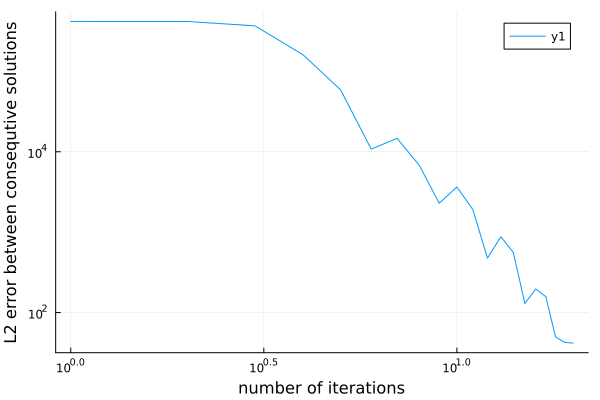

In [13]:
println(minimum(error_array))
Plots.plot(1:N_iter,error_array,yscale = :log10,xscale = :log10,xlabel="number of iterations",
ylabel = "L2 error between consequtive solutions")
#error_array
#println(maximum(c))
#println(maximum(RHS))

In [26]:
maximum(sol)

789.3883134599399

0.006940466863398856

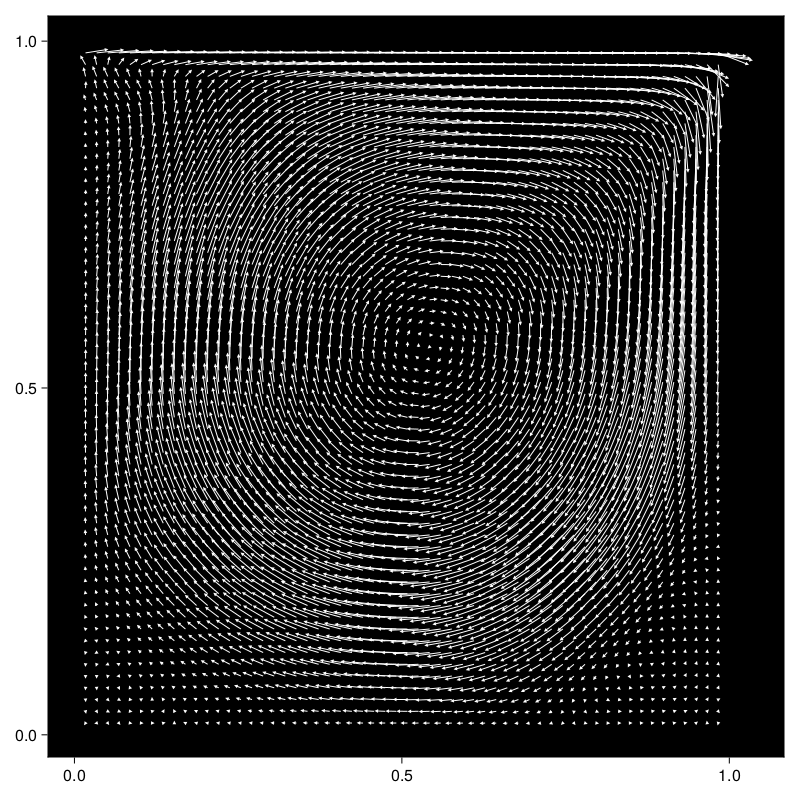

In [14]:

fig = Figure(resolution = (800, 800))
strength = sqrt.(sol[1:N_i] .^2 .+ sol[1+N_i:2*N_i] .^2)
println(minimum(strength))
Axis(fig[1, 1], backgroundcolor = "black")
arrows!(Eval_points[1,:], Eval_points[2,:], sol[1:N_eval], sol[1+N_eval:2*N_eval], arrowsize = 5,lengthscale = 0.15,
arrowcolor = :white, linecolor = :white)
fig

#### Lid driven cavity u velocity as a function of y comparison with literature for Re = 400

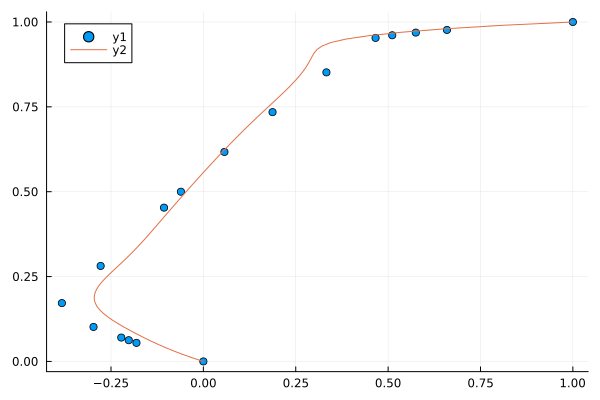

In [21]:
import CSV
import DataFrames
ref_sols = CSV.read("saved_benchmarks/reference_NS_solutions.csv",DataFrames.DataFrame)
ref_u400 = ref_sols[!,2]
ref_u1000 = ref_sols[!,3]
ref_u3200 = ref_sols[!,4]
ref_u = vec([ 1.00000 0.75837 0.68439 0.61756 0.55892 0.29093 0.16256 0.02135 -0.11477 -0.17119 -0.32726 -0.24299 -0.14612 -0.10338 -0.09266 -0.08186 0.00000])
y =vec([1.00000 0.9766 0.9688 0.9609 0.9531 0.8516 0.7344 0.6172 0.5000 0.4531 0.2813 0.1719 0.1016 0.0703 0.0625 0.0547 0.0000])

Eval_points2 = hcat(0.5*ones(100),LinRange(0,1,100))'

E_tensor2 = crete_block_point_tensors([Eval_points2],
[Internal_points,Internal_points,Boundary_points,Boundary_points])
E2 = generate_block_matrices(U_functions,E_tensor2,parameter) 
E2 = flatten(E2)
PE2 = generate_P_matrix([Eval_points2],F_PAu)
comparison = [E2 PE2]*c
Plots.scatter(ref_u1000,y)
Plots.plot!(comparison,Eval_points2[2,:])

In [22]:
import JLD
JLD.save("saved_benchmarks/NS1000_900.jld", "error", error_array, "Eval_points", Eval_points,"Eval_points2",Eval_points2, "solution",sol,"comparicon_sample",comparison )

Error encountered while save FileIO.File{FileIO.DataFormat{:JLD}, String}("saved_benchmarks/NS1000_900.jld").

Fatal error:

CapturedException: HDF5.API.H5Error: Error getting the number of members
libhdf5 Stacktrace:
 [1] H5Tget_nmembers: Invalid arguments to routine/Inappropriate type
     not a datatype
Stacktrace:
  [1] macro expansion
    @ C:\Users\Volodymyr\.julia\packages\HDF5\aiZLs\src\api\error.jl:18 [inlined]
  [2] h5t_get_nmembers(dtype_id::Int64)
    @ HDF5.API C:\Users\Volodymyr\.julia\packages\HDF5\aiZLs\src\api\functions.jl:6990
  [3] _gen_h5convert!(T::Any)
    @ JLD C:\Users\Volodymyr\.julia\packages\JLD\S6t6A\src\jld_types.jl:629
  [4] #s16#9
    @ C:\Users\Volodymyr\.julia\packages\JLD\S6t6A\src\jld_types.jl:655 [inlined]
  [5] var"#s16#9"(T::Any, ::Any, out::Any, file::Any, x::Any, wsession::Any)
    @ JLD .\none:0
  [6] (::Core.GeneratedFunctionStub)(::Any, ::Vararg{Any})
    @ Core .\boot.jl:602
  [7] write_compound(parent::JLD.JldFile, name::String, s::Adjoint{Float64, Matrix{Float64}}, wsession::JLD.JldWriteSession; kargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ JLD C:\Users\Volodymyr\.julia\packages\JLD\S6t6A\src\JLD.jl:735
  [8] write_compound
    @ C:\Users\Volodymyr\.julia\packages\JLD\S6t6A\src\JLD.jl:727 [inlined]
  [9] #_write#23
    @ C:\Users\Volodymyr\.julia\packages\JLD\S6t6A\src\JLD.jl:725 [inlined]
 [10] _write
    @ C:\Users\Volodymyr\.julia\packages\JLD\S6t6A\src\JLD.jl:725 [inlined]
 [11] #write#17
    @ C:\Users\Volodymyr\.julia\packages\JLD\S6t6A\src\JLD.jl:543 [inlined]
 [12] write(parent::JLD.JldFile, name::String, data::Adjoint{Float64, Matrix{Float64}}, wsession::JLD.JldWriteSession)
    @ JLD C:\Users\Volodymyr\.julia\packages\JLD\S6t6A\src\JLD.jl:543
 [13] (::JLD.var"#41#42"{String, Vector{Any}, Tuple{String, Matrix{Float64}, String, Adjoint{Float64, Matrix{Float64}}, String, Vector{Float64}, String, Vector{Float64}}})(file::JLD.JldFile)
    @ JLD C:\Users\Volodymyr\.julia\packages\JLD\S6t6A\src\JLD.jl:1320
 [14] jldopen(::JLD.var"#41#42"{String, Vector{Any}, Tuple{String, Matrix{Float64}, String, Adjoint{Float64, Matrix{Float64}}, String, Vector{Float64}, String, Vector{Float64}}}, ::String, ::Vararg{String}; kws::Base.Pairs{Symbol, Bool, Tuple{Symbol, Symbol}, NamedTuple{(:compatible, :compress), Tuple{Bool, Bool}}})
    @ JLD C:\Users\Volodymyr\.julia\packages\JLD\S6t6A\src\JLD.jl:262
 [15] fileio_save(::FileIO.File{FileIO.DataFormat{:JLD}, String}, ::String, ::Vector{Any}, ::String, ::Vararg{Any}; compatible::Bool, compress::Bool)
    @ JLD C:\Users\Volodymyr\.julia\packages\JLD\S6t6A\src\JLD.jl:1316
 [16] fileio_save(::FileIO.File{FileIO.DataFormat{:JLD}, String}, ::String, ::Vector{Any}, ::String, ::Vararg{Any})
    @ JLD C:\Users\Volodymyr\.julia\packages\JLD\S6t6A\src\JLD.jl:1312
 [17] invokelatest(::Any, ::Any, ::Vararg{Any}; kwargs::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ Base .\essentials.jl:816
 [18] invokelatest(::Any, ::Any, ::Vararg{Any})
    @ Base .\essentials.jl:813
 [19] action(::Symbol, ::Vector{Union{Base.PkgId, Module}}, ::FileIO.Formatted, ::String, ::Vararg{Any}; options::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ FileIO C:\Users\Volodymyr\.julia\packages\FileIO\BE7iZ\src\loadsave.jl:219
 [20] action(::Symbol, ::Vector{Union{Base.PkgId, Module}}, ::FileIO.Formatted, ::String, ::Vector{Any}, ::Vararg{Any})
    @ FileIO C:\Users\Volodymyr\.julia\packages\FileIO\BE7iZ\src\loadsave.jl:196
 [21] action(::Symbol, ::Vector{Union{Base.PkgId, Module}}, ::Symbol, ::String, ::String, ::Vararg{Any}; options::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ FileIO C:\Users\Volodymyr\.julia\packages\FileIO\BE7iZ\src\loadsave.jl:185
 [22] action(::Symbol, ::Vector{Union{Base.PkgId, Module}}, ::Symbol, ::String, ::String, ::Vararg{Any})
    @ FileIO C:\Users\Volodymyr\.julia\packages\FileIO\BE7iZ\src\loadsave.jl:185
 [23] save(::String, ::String, ::Vararg{Any}; options::Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}})
    @ FileIO C:\Users\Volodymyr\.julia\packages\FileIO\BE7iZ\src\loadsave.jl:129
 [24] save(::String, ::String, ::Vector{Any}, ::Vararg{Any})
    @ FileIO C:\Users\Volodymyr\.julia\packages\FileIO\BE7iZ\src\loadsave.jl:125
 [25] top-level scope
    @ c:\Users\Volodymyr\OneDrive\Documents\Masters\thesis\coding\Stationary-NS_experimental.ipynb:2

In [20]:
JLD.load("saved_benchmarks/NS1000_40.jld")

Dict{String, Any} with 5 entries:
  "Eval_points"       => [0.0169492 0.0169492 … 0.983051 0.983051; 0.0169492 0.…
  "Eval_points2"      => [0.5 0.5 … 0.5 0.5; 0.0 0.010101 … 0.989899 1.0]
  "error"             => Any[4.18101e5, 4.17686e5, 3.68753e5, 1.60347e5, 58802.…
  "comparicon_sample" => [-2.56959e-7, -0.0284193, -0.0547813, -0.0792299, -0.1…
  "solution"          => [-0.00138711, 0.000436073, 0.000162947, -0.000200972, …

In [145]:
v20 = load("saved_benchmarks/NS_20.jld")
v40 = load("saved_benchmarks/NS_40.jld")
v60 = load("saved_benchmarks/NS_60.jld")
display(v20)
Plots.scatter(ref_u,y,label = "reference solution",legend = :bottomright,xlabel="x",ylabel="u")
Plots.plot!(v20["comparicon_sample"],v20["Eval_points2"][2,:],linestyle = :dash,label = L"h = \frac{1}{20}")
Plots.plot!(v40["comparicon_sample"],v40["Eval_points2"][2,:],linestyle = :dashdot,label = L"h = \frac{1}{40}")
Plots.plot!(v60["comparicon_sample"],v60["Eval_points2"][2,:],label = L"h = \frac{1}{60}")
savefig("report_figures/Navier_Stokes.png")

Dict{String, Any} with 5 entries:
  "Eval_points"       => [0.0169492 0.0169492 … 0.983051 0.983051; 0.0169492 0.…
  "Eval_points2"      => [0.5 0.5 … 0.5 0.5; 0.0 0.010101 … 0.989899 1.0]
  "error"             => Any[10977.5, 9159.26, 6227.88, 1622.92, 290.723, 137.4…
  "comparicon_sample" => [-3.64448e-7, -0.0130754, -0.0248367, -0.0356045, -0.0…
  "solution"          => [-0.00388927, -0.00285534, -0.000549105, 0.000804475, …

"c:\\Users\\Volodymyr\\OneDrive\\Documents\\Masters\\thesis\\coding\\report_figures\\Navier_Stokes.png"

In [176]:
using CSV
using DataFrames
ref_sols = CSV.read("saved_benchmarks/reference_NS_solutions.csv", DataFrame)
#sdsd[!,2]

Row,100,400,1000,3200,5000,7500,"10,000"
,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.84123,0.75837,0.65928,0.53236,0.48223,0.47244,0.47221
3,0.78871,0.68439,0.57492,0.48296,0.4612,0.47048,0.47783
4,0.73722,0.61756,0.51117,0.46547,0.45992,0.47323,0.4807
5,0.68717,0.55892,0.46604,0.46101,0.46036,0.47167,0.47804
6,0.23151,0.29093,0.33304,0.34682,0.33556,0.34228,0.34635
7,0.00332,0.16256,0.18719,0.19791,0.20087,0.20591,0.20673
8,-0.13641,0.02135,0.05702,0.07156,0.08183,0.08342,0.08344
9,-0.20581,-0.11477,-0.0608,-0.04272,-0.03039,-0.038,0.03111
